# Continuous Control

---

In this notebook, a solution for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) is provided.

### 1. Setup the Environment

At first some necessary packages need to be imported. This requires [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/) and [Matplotlib](https://matplotlib.org/) to be installed.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Create a DDPG Agent

In this solution a DDPG agent that implements an off-policy training with gradient clipping, soft target update and experience replay will be trained to solve the reacher environment. It it first initialized with the state and action sizes.

In [5]:
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

### 4. Define the Training Process
The training runs up to 1000 episodes with up 1000 time steps per episode. Once the mean score over the last 100 subsequent episodes hits or exceeds +30 points the environement is solved and the training process ends.

The actor and critic networks are fully-connected neural networks with two hidden layers of 400 and 300 nodes respectively and relu activations. Before the activations in the first hidden layer a batch normalization is conducted in both networks. The actor has a final tanh activation to retrieve actions in the range -1 to 1.

In [6]:
from collections import deque

def ddpg(n_episodes=1000, max_t=1000, print_every=5):
    total_scores_deque = deque(maxlen=100)
    total_scores = []                                            # initialize the total scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
        states = env_info.vector_observations                    # get the current states
        
        agent.reset()
        scores = np.zeros(num_agents)
        for i in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]             # send all actions to the environment
            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = env_info.rewards                           # get reward (for each agent)
            dones = env_info.local_done                          # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones, i % 20 == 0)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        
        total_scores_deque.append(np.mean(scores))               # save scores
        total_scores.append(np.mean(scores))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(total_scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(total_scores_deque)))
            
        if i_episode >= 100 and np.mean(total_scores_deque) >= 30.0:
            print('\r\nEnvironment solved after {} episodes'.format(i_episode))
            break
            
    return total_scores

### 5. Train the DDPG Agent
Start the training until an average score of +30 is achieved by the agent.

Episode 5	Average Score: 0.58
Episode 10	Average Score: 1.10
Episode 15	Average Score: 1.92
Episode 20	Average Score: 3.91
Episode 25	Average Score: 7.53
Episode 30	Average Score: 11.87
Episode 35	Average Score: 15.52
Episode 40	Average Score: 18.31
Episode 45	Average Score: 20.53
Episode 50	Average Score: 22.32
Episode 55	Average Score: 23.81
Episode 60	Average Score: 25.04
Episode 65	Average Score: 26.06
Episode 70	Average Score: 26.98
Episode 75	Average Score: 27.75
Episode 80	Average Score: 28.42
Episode 85	Average Score: 28.97
Episode 90	Average Score: 29.45
Episode 95	Average Score: 29.89
Episode 100	Average Score: 30.31

Environment solved after 100 episodes


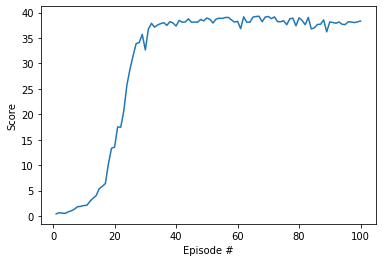

In [7]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Store Model and Clean Up
Save the trained model.

In [8]:
import torch

torch.save(agent.actor_local.state_dict(), 'stored_model_actor.pth')
torch.save(agent.critic_local.state_dict(), 'stored_model_critic.pth')

When finished, you can close the environment.

In [9]:
env.close()